In [29]:
# Load libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MaxAbsScaler

# Load dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Transform data into valid input to the nn-model. 
le = LabelEncoder()
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(train['Text'])
le.fit(train['Category'])
x_train = tfidf_vectorizer.transform(train['Text'])
y_train = le.transform(train['Category'])
#print(x_train.shape[0])
#print(y_train.shape[0])

x_test = tfidf_vectorizer.transform(test['Text'])
y_test = le.transform(test['Category'])
#print(x_test.shape[0])
#print(y_test.shape[0])

scaler = MaxAbsScaler()
scaler.fit(x_train)

#Hide warnings if you want
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [30]:
def k_fold_data(train, k=5):
        n = len(train)
        fold_size = n // k
        folds = []

        for i in range(k):
            start = i * fold_size
            end = (i + 1) * fold_size if i < k - 1 else n  # handle last fold

            val_set = train.iloc[start:end]
            train_set = pd.concat([train.iloc[:start], train.iloc[end:]])

            folds.append((train_set, val_set))
        
        return folds

five_fold = k_fold_data(train, 5)




In [31]:
from collections import Counter
import numpy as np
from sklearn.neural_network import MLPClassifier 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score #Some imports that are useful in runnning NN. 

In [32]:
def nn(x_train, y_train, unit_size): #This returns a model for which you can predict upon input of testing datas.
    x_train = scaler.transform(x_train)
    clf = MLPClassifier(hidden_layer_sizes=(unit_size,), activation='relu', solver='adam', max_iter=1, random_state=1, warm_start=True)
    clf.fit(x_train, y_train) #initialise weight here
    rng = np.random.RandomState(1)
    clf.coefs_[0] = rng.uniform(0, 0.1, size=clf.coefs_[0].shape) #deliberately initialise weight again from 0 to 0.1
    clf.max_iter = 100
    clf.fit(x_train, y_train)
    
    return clf

def average_entropy_train_loss(y_pred, y_true):
    n = len(y_true)
    loss = 0
    for i in range(n):
        if y_true[i] == 0:
            loss += -np.log(y_pred[i][0])
        else:
            loss += -np.log(y_pred[i][1])
    
    return loss/n

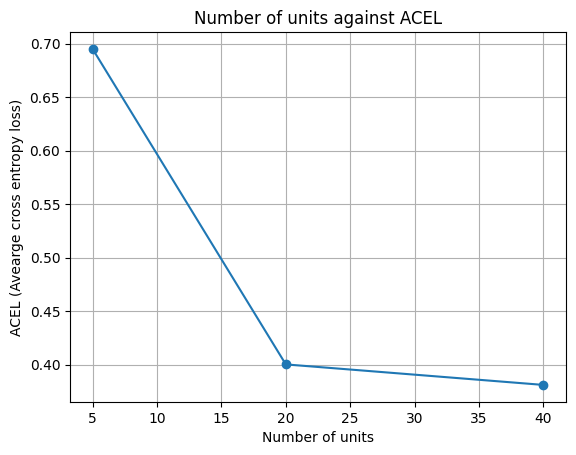

Prediction accuracy:  0.4953271028037383 0.9929906542056075 1.0



In [33]:
clf5 = nn(x_train, y_train, 5)
clf20 = nn(x_train, y_train, 20)
clf40 = nn(x_train, y_train, 40)

pred5 = clf5.predict_proba(x_train)
pred20 = clf20.predict_proba(x_train)
pred40 = clf40.predict_proba(x_train)


number_of_units = [5, 20, 40]
ACELs = [average_entropy_train_loss(pred5, y_train), average_entropy_train_loss(pred20, y_train), average_entropy_train_loss(pred40, y_train)]

plt.plot(number_of_units, ACELs, marker='o')  # 'marker' adds dots at each point
plt.xlabel('Number of units')
plt.ylabel('ACEL (Avearge cross entropy loss)')
plt.title('Number of units against ACEL')
plt.grid(True)
plt.show()

pred5 = clf5.predict(x_train)
pred20 = clf20.predict(x_train)
pred40 = clf40.predict(x_train)

print("Prediction accuracy: ", accuracy_score(y_train, pred5), accuracy_score(y_train, pred20), accuracy_score(y_train, pred40))
print()



As the number of units increase, the ACEL on the training data seems to be getting lower and lower. There is a huge drop of ACEL from unit number of 5 to unit number of 20, but isn't a huge drop from 20 to 40 units. This could be due to irreducible bias. Meaning the model cannot be improved anymore. THe prediction accuracy again confirms that, with 20 units having a training accuracy of 99%. Further learning could lead to overfitting.  

All above cooresponds to question 2d, all below are for question 3 of nn

In [34]:
def mportion_nn(x_train, y_train, unit_size, m): #This returns a model for which you can predict upon input of testing datas.
    n = int(x_train.shape[0] * m)
    x_train = x_train[:n]
    y_train = y_train[:n]
    scaler = MaxAbsScaler()
    scaler.fit(x_train)
    x = scaler.transform(x_train)
    y = y_train
    clf = MLPClassifier(hidden_layer_sizes=(unit_size,), activation='relu', solver='adam', max_iter=1, random_state=1, warm_start=True)
    clf.fit(x, y) #initialise weight here
    rng = np.random.RandomState(1)
    clf.coefs_[0] = rng.uniform(0, 0.1, size=clf.coefs_[0].shape) #deliberately initialise weight again from 0 to 0.1
    clf.max_iter=100
    clf.fit(x, y)
    
    return clf, scaler

In [35]:
#Assume a unit of 20, we can compute the train_accuracy upon diffeernt size of traing set:

clf10, scaler10 = mportion_nn(x_train, y_train, 20, 0.1)
clf30, scaler30 = mportion_nn(x_train, y_train, 20, 0.3)
clf50, scaler50 = mportion_nn(x_train, y_train, 20, 0.5)
clf70, scaler70 = mportion_nn(x_train, y_train, 20, 0.7)
clf90, scaler90 = mportion_nn(x_train, y_train, 20, 0.9)

input10train, input10test = scaler10.transform(x_train), scaler10.transform(x_test)
print("10 percent f1(train):", f1_score(y_train, clf10.predict(input10train)), "f1(test):", f1_score(y_test, clf10.predict(input10test)))
input30train, input30test = scaler30.transform(x_train), scaler30.transform(x_test)
print("30 percent f1(train):", f1_score(y_train, clf30.predict(input30train)), "f1(test):", f1_score(y_test, clf30.predict(input30test)))
input50train, input50test = scaler50.transform(x_train), scaler50.transform(x_test)
print("50 percent f1(train):", f1_score(y_train, clf50.predict(input50train)), "f1(test):", f1_score(y_test, clf50.predict(input50test)))
input70train, input70test = scaler70.transform(x_train), scaler70.transform(x_test)
print("70 percent f1(train):", f1_score(y_train, clf70.predict(input70train)), "f1(test):", f1_score(y_test, clf70.predict(input70test)))
input90train, input90test = scaler90.transform(x_train), scaler90.transform(x_test)
print("90 percent f1(train):", f1_score(y_train, clf90.predict(input90train)), "f1(test):", f1_score(y_test, clf90.predict(input90test)))



10 percent f1(train): 0.7783783783783784 f1(test): 0.743801652892562
30 percent f1(train): 0.9344978165938864 f1(test): 0.88
50 percent f1(train): 0.9684684684684685 f1(test): 0.946236559139785
70 percent f1(train): 0.9885057471264368 f1(test): 0.9574468085106383
90 percent f1(train): 1.0 f1(test): 0.9782608695652174


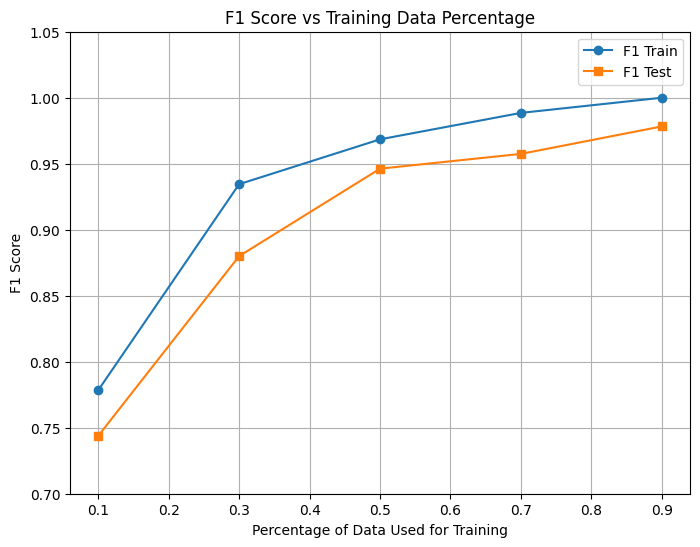

In [36]:
f1train = [0.7783783783783784, 0.9344978165938864, 0.9684684684684685, 0.9885057471264368, 1.0]
f1test = [0.743801652892562, 0.88, 0.946236559139785, 0.9574468085106383, 0.9782608695652174]
percentage = [0.1, 0.3, 0.5, 0.7, 0.9]

plt.figure(figsize=(8, 6))
plt.plot(percentage, f1train, marker='o', label='F1 Train')
plt.plot(percentage, f1test, marker='s', label='F1 Test')

# Labels and title
plt.xlabel("Percentage of Data Used for Training")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Training Data Percentage")
plt.ylim(0.7, 1.05)
plt.grid(True)
plt.legend()

# Show the plot
plt.show()



In [37]:
from sklearn.model_selection import cross_val_score #Why not using this? Because the assignment specifies that the initial weight has to be between [0, 0.1]

def cross_validate(folds, unit_size, activation = 'relu'):
    accuracy = 0
    n = len(folds)
    
    for i in range(n):
        tfidf_vectorizer = TfidfVectorizer()
        scaler = MaxAbsScaler()
        tfidf_vectorizer.fit(folds[i][0]['Text'])
        x_train = tfidf_vectorizer.transform(folds[i][0]['Text'])
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        y_train = le.transform(folds[i][0]['Category'])
        x_test = tfidf_vectorizer.transform(folds[i][1]['Text'])
        x_test = scaler.transform(x_test)
        y_test = le.transform(folds[i][1]['Category'])
        
        clf = MLPClassifier(hidden_layer_sizes=(unit_size,), activation=activation, solver='adam', max_iter=1, random_state=1, warm_start=True)
        clf.fit(x_train, y_train) #initialise weight here
        rng = np.random.RandomState(1)
        clf.coefs_[0] = rng.uniform(0, 0.1, size=clf.coefs_[0].shape) #deliberately initialise weight again from 0 to 0.1, which is what cross_val_score() can't do
        clf.max_iter=100
        clf.fit(x_train, y_train)

        y_pred = clf.predict(x_test)
        accuracy += accuracy_score(y_test, y_pred)
    
    return accuracy/n

In [38]:
print("5 units: (logistic)", cross_validate(five_fold, 5, 'logistic'))
print("20 units: (logistic)", cross_validate(five_fold, 20, 'logistic'))
print("40 units: (logistic)", cross_validate(five_fold, 40, 'logistic'))
print("5 units: (relu)", cross_validate(five_fold, 5, 'relu'))
print("20 units: (relu)", cross_validate(five_fold, 20, 'relu'))
print("40 units: (relu)", cross_validate(five_fold, 40, 'relu'))

5 units: (logistic) 0.9577272727272726
20 units: (logistic) 0.7610962566844919
40 units: (logistic) 0.9600802139037432
5 units: (relu) 0.962433155080214
20 units: (relu) 0.8575668449197862
40 units: (relu) 0.9483155080213903


Parameters userd in NN:
    - number of layers (fix to 1)
    - bias (not used here)
    - number of units per layer(unit_size which is tunable)
    - activation Functions (tunable here, default is relu)
    - learning rate (fix to 0.01)
    - epochs (fix to 100)
    - optimizer (not explored here)
    - regulartion (not explored here)

    The key parameters being used here are the unit_size and activation function. 

It seems like NN performs the best with unit number of 5, which achive a training accuracy of 96.2%(with relu activation function), and the worst with unit number of 20, only 85%. The use of activation function doesn't seem to have huge effect on the prediction outcome with the current implementation(except for 20 units, which indicates that relu is doing better here). All of the above results are based on training set, nothing to do with testing data. 

As the size of the training set increases, the F1 score on the training and testing dataset is increasing. This tells us that the testing data could be in high similarity to the training data. 